Запускаем сесию pyspark

In [32]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local[1]")\
        .appName('Proekt')\
        .getOrCreate()

Импортируем библиотеки

In [33]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from functools import reduce
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
from pyspark.sql.functions import col, avg
from collections.abc import MutableSequence
import plotly.graph_objs as go
from plotly.offline import iplot
from pyspark.sql.functions import size, when
from pyspark.sql.functions import mean
from pyspark.sql.functions import desc
import plotly.express as px
import pyspark.sql as sparksql
from pyspark_dist_explore import Histogram, hist


Считываем датасет и выводим основную информацию по нему

In [34]:
df = spark.read.csv(
    "russian_demography.csv",
    sep=",",
    header=True,
    inferSchema=True # Позволяет Spark автоматически определить типы данных
)


print(f"Количество строк: {df.count()}")
print(f"Количество столбцов: {len(df.columns)}")
print("\nСхема:")
df.printSchema()

Количество строк: 2380
Количество столбцов: 7

Схема:
root
 |-- year: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- npg: double (nullable = true)
 |-- birth_rate: double (nullable = true)
 |-- death_rate: double (nullable = true)
 |-- gdw: double (nullable = true)
 |-- urbanization: double (nullable = true)



выводим весь датасет

In [35]:
df.show(2380)

+----+--------------------+-----+----------+----------+-----+------------+
|year|              region|  npg|birth_rate|death_rate|  gdw|urbanization|
+----+--------------------+-----+----------+----------+-----+------------+
|1990|  Republic of Adygea|  1.9|      14.2|      12.3|84.66|       52.42|
|1990|          Altai Krai|  1.8|      12.9|      11.1|80.24|       58.07|
|1990|         Amur Oblast|  7.6|      16.2|       8.6|69.55|       68.37|
|1990|  Arkhangelsk Oblast|  3.7|      13.5|       9.8|73.26|       73.63|
|1990|    Astrakhan Oblast|  4.7|      15.1|      10.4|77.05|       68.01|
|1990|Republic of Bashk...|  6.5|      16.2|       9.7|80.53|       64.22|
|1990|     Belgorod Oblast|  0.0|      12.9|      12.9|84.17|       63.26|
|1990|      Bryansk Oblast|  0.1|      13.0|      12.9|86.48|       67.49|
|1990|Republic of Buryatia|  9.2|      18.3|       9.1|79.47|       62.16|
|1990|     Vladimir Oblast| -0.4|      12.1|      12.5|77.78|       79.31|
|1990|    Volgograd Oblas

удаляем нулевые строки и выводим количество оставшихся строк и оставшийся датасет

In [36]:
df= df.filter(reduce(lambda x, y: x & y,
                      [col(c).isNotNull() for c in df.columns]))

print(f"Количество строк: {df.count()}")
print(f"Количество столбцов: {len(df.columns)}")
df.show(2380)

Количество строк: 2315
Количество столбцов: 7
+----+--------------------+-----+----------+----------+-----+------------+
|year|              region|  npg|birth_rate|death_rate|  gdw|urbanization|
+----+--------------------+-----+----------+----------+-----+------------+
|1990|  Republic of Adygea|  1.9|      14.2|      12.3|84.66|       52.42|
|1990|          Altai Krai|  1.8|      12.9|      11.1|80.24|       58.07|
|1990|         Amur Oblast|  7.6|      16.2|       8.6|69.55|       68.37|
|1990|  Arkhangelsk Oblast|  3.7|      13.5|       9.8|73.26|       73.63|
|1990|    Astrakhan Oblast|  4.7|      15.1|      10.4|77.05|       68.01|
|1990|Republic of Bashk...|  6.5|      16.2|       9.7|80.53|       64.22|
|1990|     Belgorod Oblast|  0.0|      12.9|      12.9|84.17|       63.26|
|1990|      Bryansk Oblast|  0.1|      13.0|      12.9|86.48|       67.49|
|1990|Republic of Buryatia|  9.2|      18.3|       9.1|79.47|       62.16|
|1990|     Vladimir Oblast| -0.4|      12.1|      12.5

График естественного приросты убыли населения с 1990 по 2017

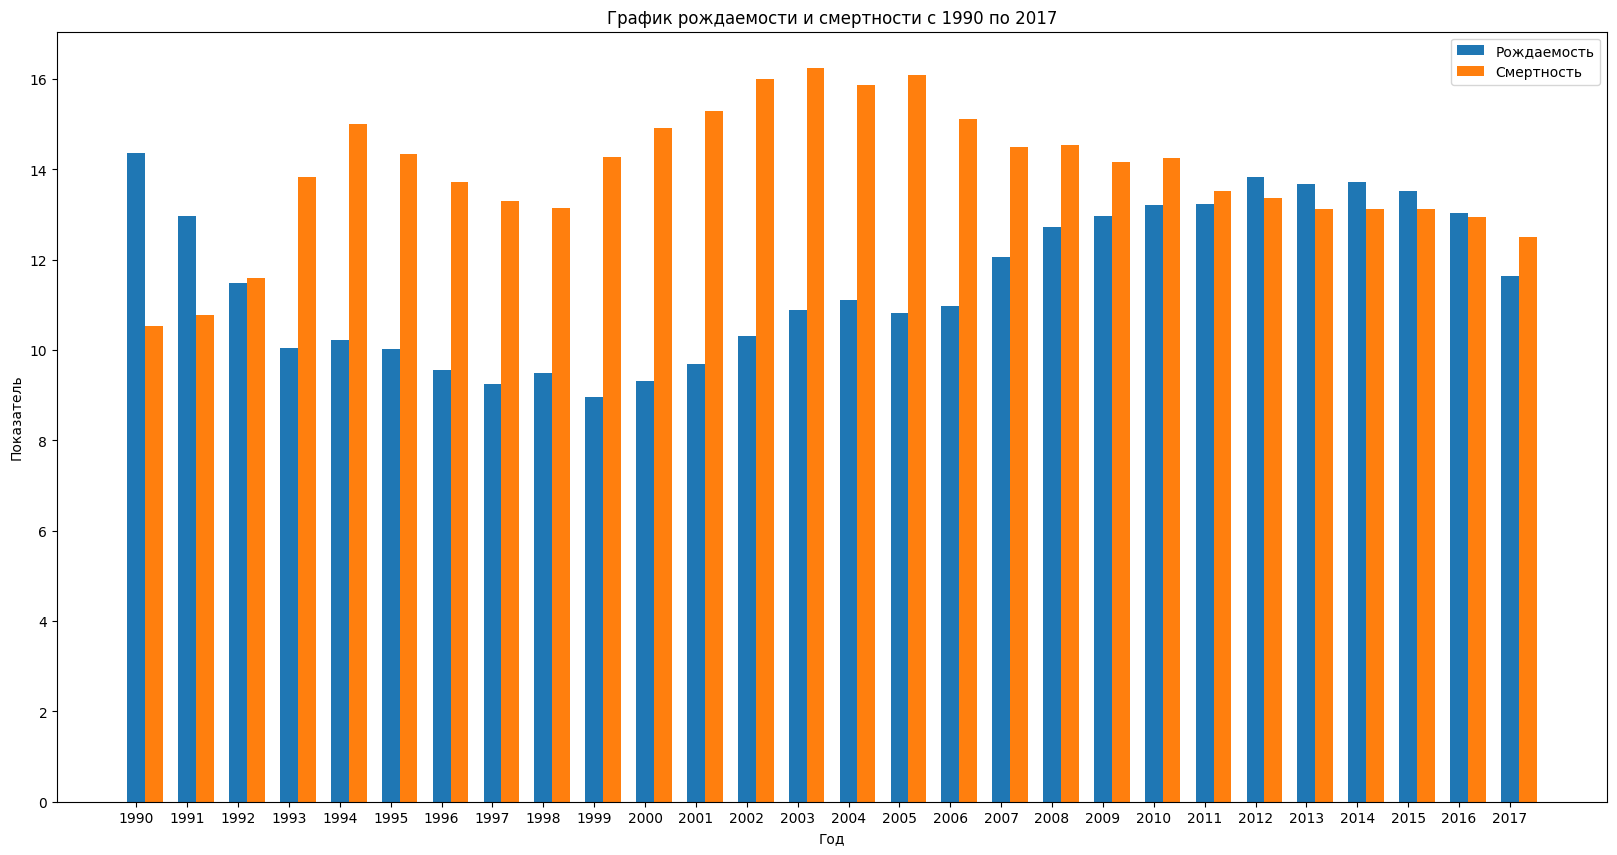

In [37]:
#Группировка по году и вычисление средних значений
grouped_df = df.groupBy("year").agg(
    avg("birth_rate").alias("mean_birth_rate"),
    avg("death_rate").alias("mean_death_rate")
)

#Преобразование Spark DataFrame в Pandas DataFrame
pandas_df = grouped_df.toPandas()

#Построение столбчатой диаграммы
plt.figure(figsize=(20, 10))

#Создание двух столбчатых диаграмм рядом друг с другом
width = 0.35  # Ширина столбца
plt.bar(pandas_df["year"], pandas_df["mean_birth_rate"], width, label='Рождаемость')
plt.bar(pandas_df["year"] + width, pandas_df["mean_death_rate"], width, label='Смертность')

plt.xlabel("Год")
plt.ylabel("Показатель")
plt.title("График рождаемости и смертности с 1990 по 2017")
plt.xticks(pandas_df["year"])  # Установка меток на оси x
plt.legend()
plt.show()

Топ 10 регионов с самой высокой рождаемостью с 1990 по 2017

+--------------------+------------------+------------------+
|              region|   mean_birth_rate|   mean_death_rate|
+--------------------+------------------+------------------+
|    Chechen Republic|25.083333333333332| 5.627777777777777|
|       Tuva Republic|21.703571428571426| 11.99642857142857|
|Republic of Ingus...|19.378260869565217| 4.565217391304347|
|Republic of Dagestan|18.414285714285718| 6.124999999999999|
|      Altai Republic|17.396428571428572| 12.59285714285714|
|Sakha (Yakutia) R...|15.725000000000003| 9.214285714285714|
|Nenets Autonomous...|15.153571428571427|11.035714285714283|
|Republic of Buryatia|14.528571428571428|12.503571428571428|
|Yamalo-Nenets Aut...|14.174999999999999| 5.421428571428573|
|Republic of Kalmykia|14.146428571428574|            10.325|
+--------------------+------------------+------------------+



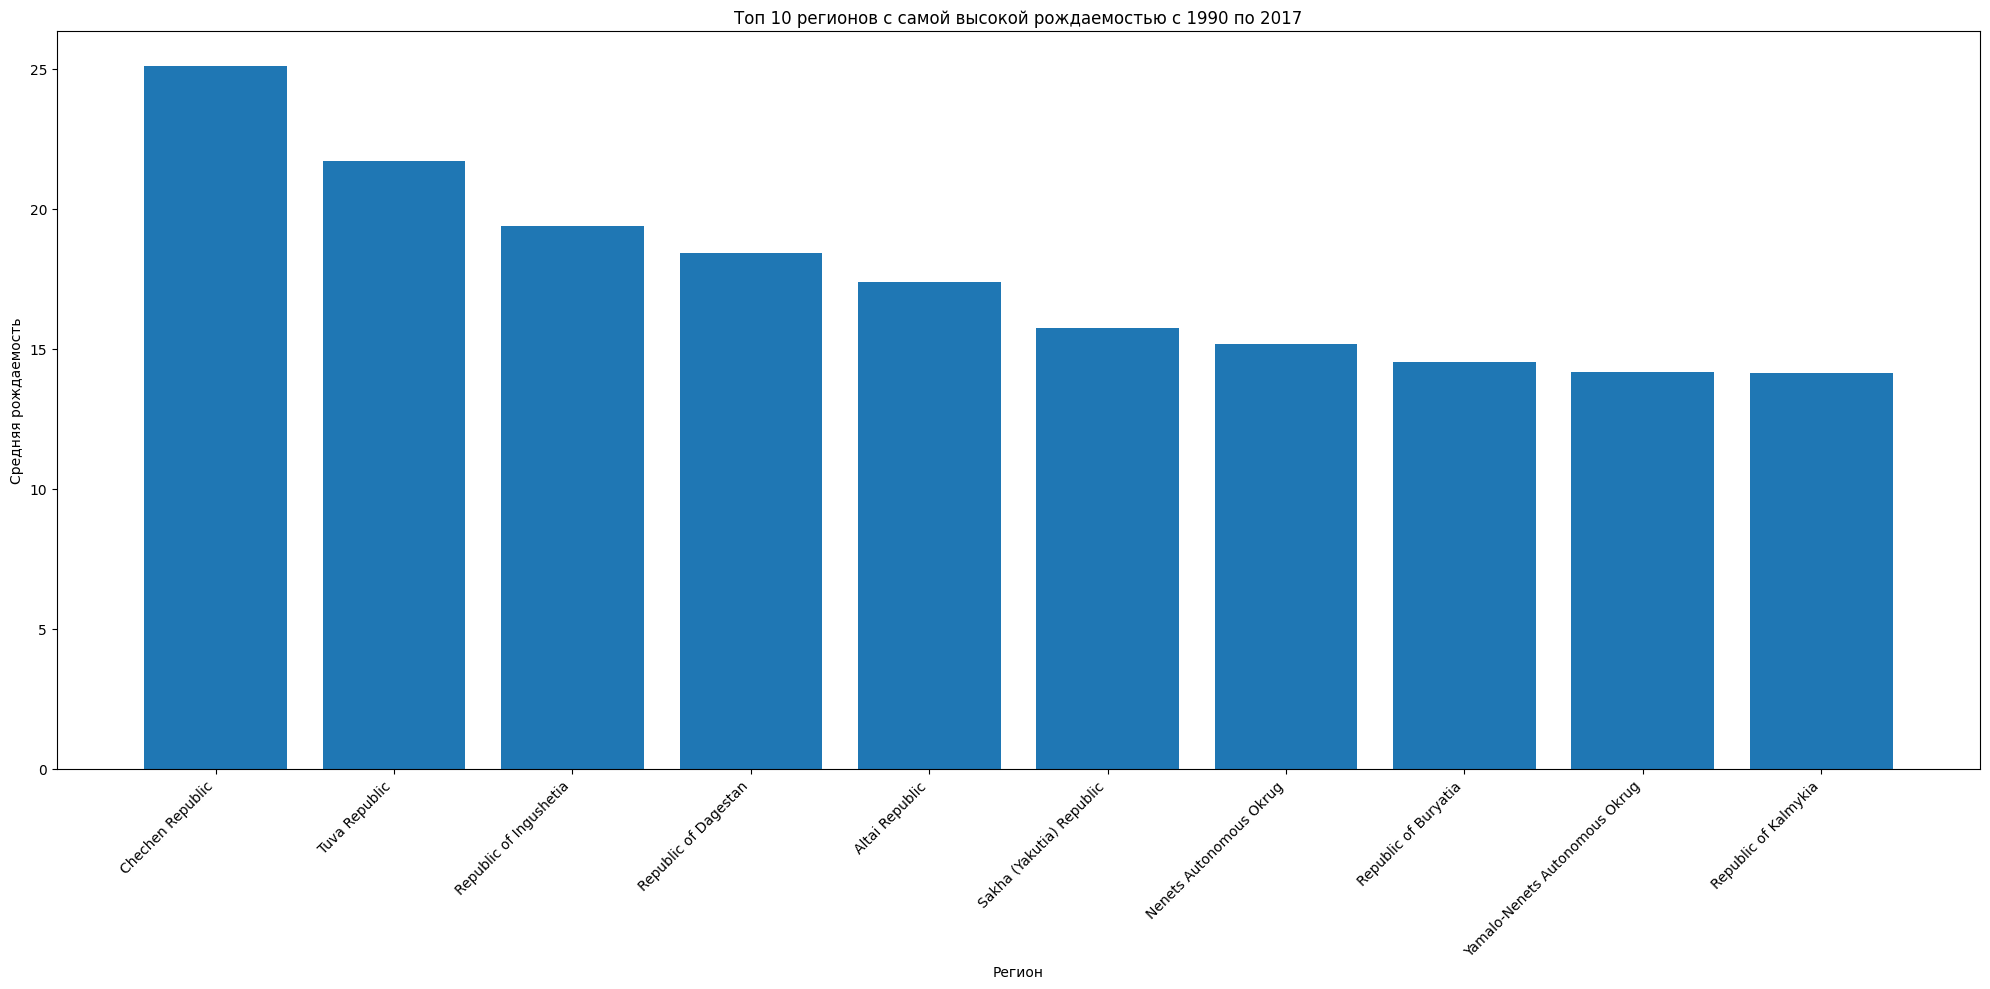

In [61]:
dfTopBirth = df.groupBy("region") \
                .agg(avg("birth_rate").alias("mean_birth_rate"),
                     avg("death_rate").alias("mean_death_rate")) \
                .orderBy("mean_birth_rate", ascending=False) \
                .limit(10)

dfTopBirth.show()
# Преобразование в Pandas DataFrame для построения графика
pandas_df = dfTopBirth.toPandas()

# Построение столбчатой диаграммы
plt.figure(figsize=(20, 10))
plt.bar(pandas_df["region"], pandas_df["mean_birth_rate"], label='Средняя рождаемость')
plt.xlabel("Регион")
plt.ylabel("Средняя рождаемость")
plt.title("Топ 10 регионов с самой высокой рождаемостью с 1990 по 2017")
plt.xticks(rotation=45, ha="right")  # Поворот подписей оси X для лучшей читаемости
plt.tight_layout()  # Настройка макета, чтобы подписи не накладывались
plt.show()


Топ 10 регионов с самым высоким коэффициентом смертности с 1990 по 2017

+---------------+------------------+------------------+
|         region|   mean_death_rate|   mean_birth_rate|
+---------------+------------------+------------------+
|   Pskov Oblast|            20.425| 9.317857142857141|
|    Tver Oblast|19.685714285714287| 9.478571428571428|
|Novgorod Oblast|19.107142857142854|  9.80714285714286|
|    Tula Oblast| 18.86785714285715| 8.410714285714286|
| Ivanovo Oblast| 18.27142857142857| 9.196428571428571|
|Smolensk Oblast|17.885714285714286| 9.160714285714288|
|  Ryazan Oblast|17.607142857142858| 9.096428571428572|
|Kostroma Oblast|17.467857142857145|10.264285714285716|
|   Kursk Oblast|17.328571428571433| 9.789285714285715|
|  Tambov Oblast|17.300000000000004| 8.939285714285713|
+---------------+------------------+------------------+



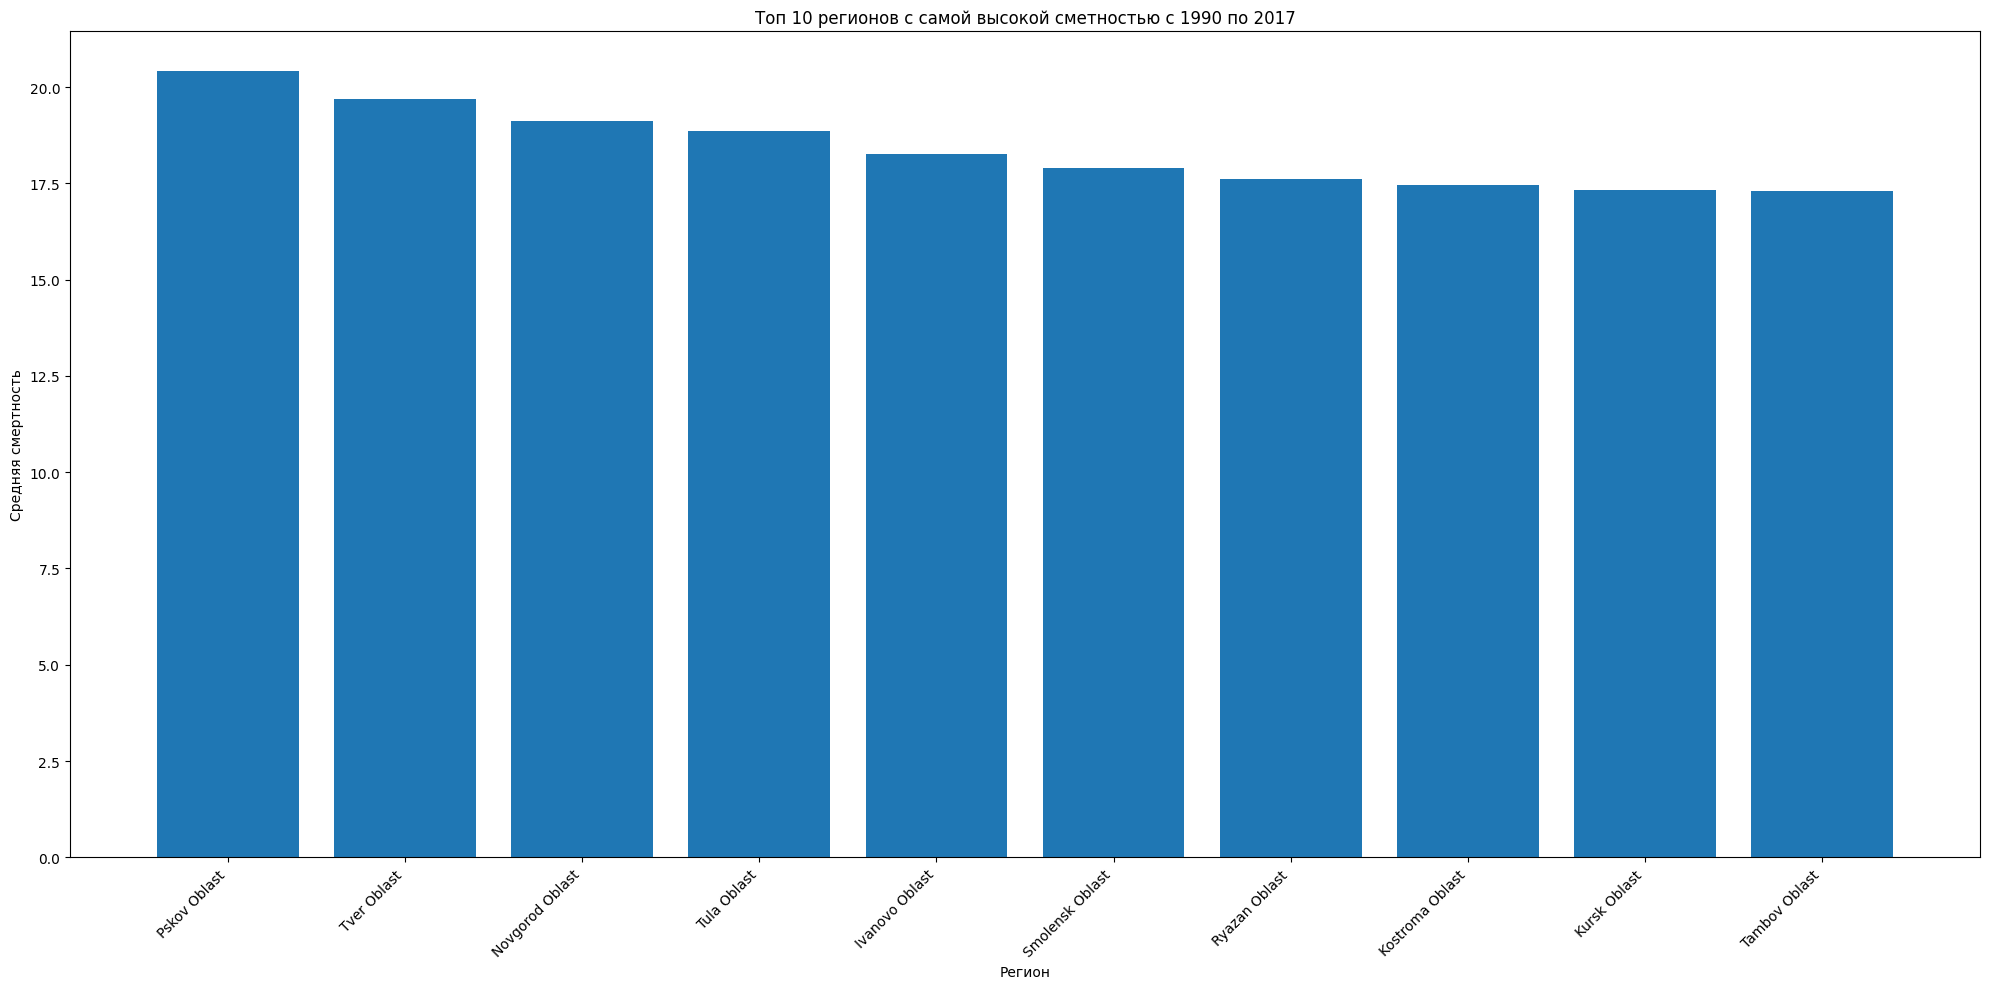

In [62]:
dfTopDeath = df.groupBy("region") \
                .agg(avg("death_rate").alias("mean_death_rate"),
                     avg("birth_rate").alias("mean_birth_rate")) \
                .orderBy("mean_death_rate", ascending=False) \
                .limit(10)

dfTopDeath.show()


#Преобразование в Pandas DataFrame для построения графика
pandas_df = dfTopDeath.toPandas()

#Построение столбчатой диаграммы
plt.figure(figsize=(20, 10))
plt.bar(pandas_df["region"], pandas_df["mean_death_rate"], label='Средняя смертность')
plt.xlabel("Регион")
plt.ylabel("Средняя смертность")
plt.title("Топ 10 регионов с самой высокой сметностью с 1990 по 2017")
plt.xticks(rotation=45, ha="right")  # Поворот подписей оси X для лучшей читаемости
plt.tight_layout()  # Настройка макета, чтобы подписи не накладывались
plt.show()

Посмотрим на зависимость демографического показателя и количества городского населения

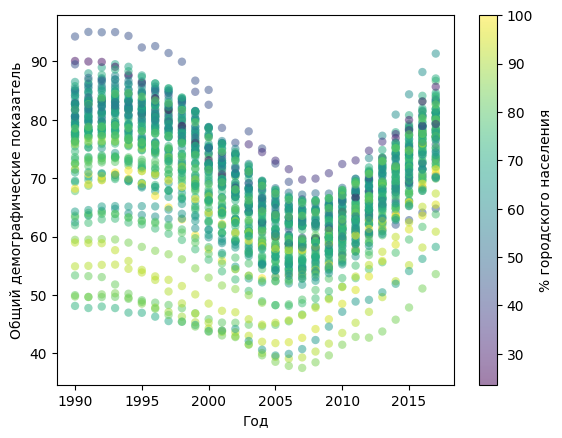

In [40]:
pandas_df = df.select('year', 'gdw', 'urbanization').toPandas()

# Строим scatter plot
fig = plt.scatter(pandas_df['year'], pandas_df['gdw'], label=None,
            c=pandas_df['urbanization'], cmap='viridis',
            linewidth=0, alpha=0.5)
plt.xlabel('Год')
plt.ylabel('Общий демографические показатель')
plt.colorbar(label='% городского населения')
plt.show()


Демография  в Ростовской области

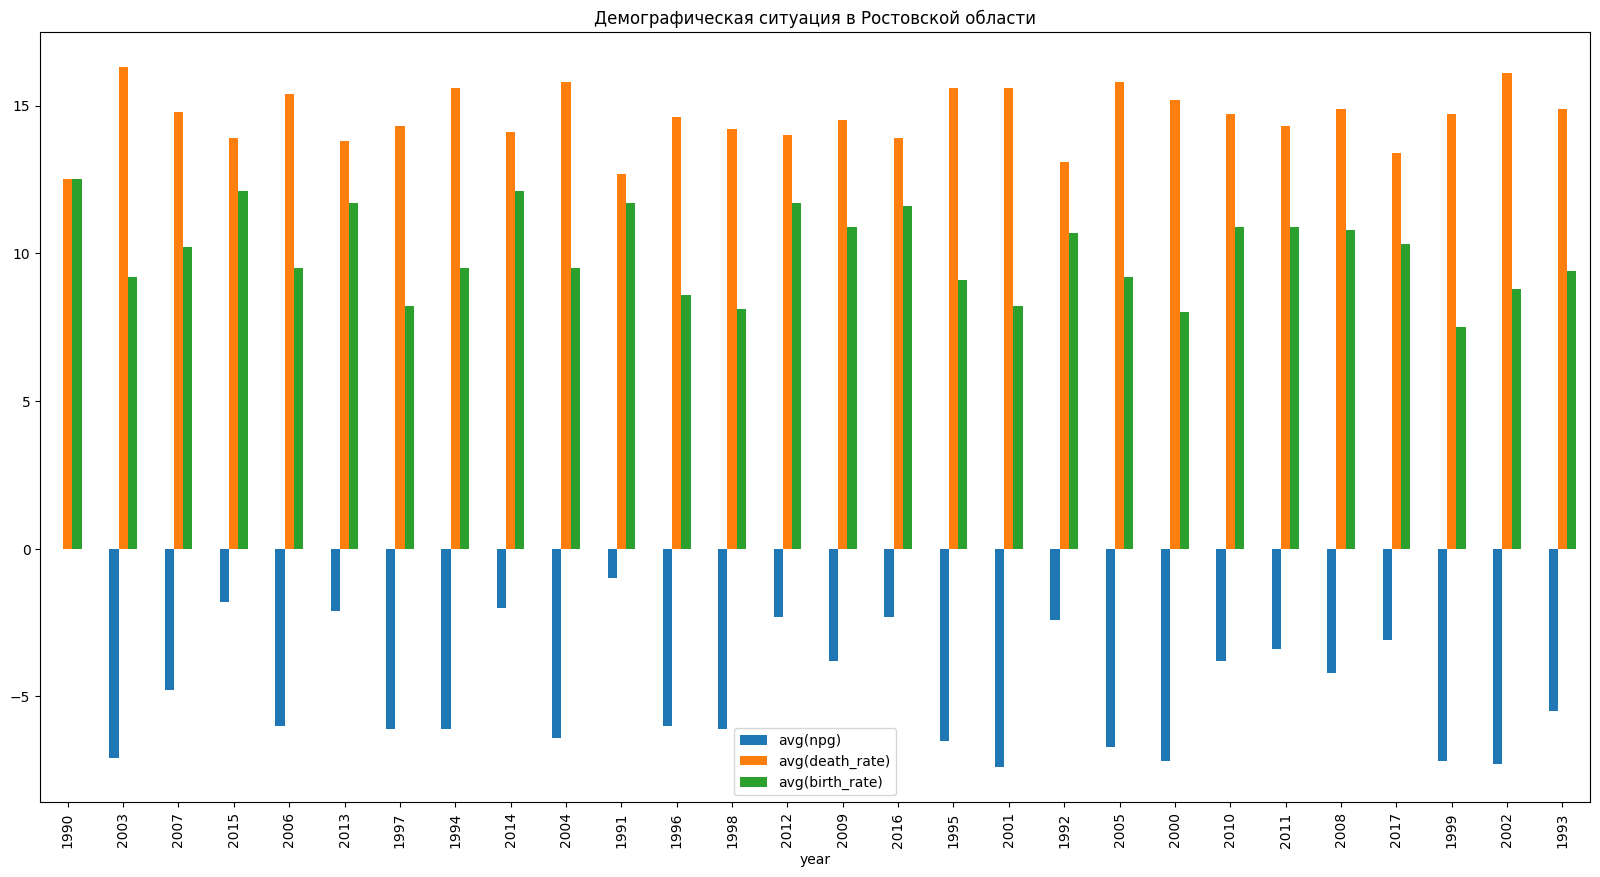

In [41]:
df_rostov = df.filter(df.region == 'Rostov Oblast').groupBy('year').agg({'birth_rate':'avg', 'death_rate':'avg', 'npg':'avg'})

# Преобразование DataFrame в pandas DataFrame для построения графика
pandas_df_rostov = df_rostov.toPandas()

# Построение столбчатой диаграммы
pandas_df_rostov.plot.bar(x='year', figsize=(20, 10), title='Демографическая ситуация в Ростовской области')
plt.show()

В итоге можно делать вывод, что демографическая ситуация в России не в лучшем положении, по крайне мере в период с 1990 по 2017 года.

In [42]:
# Рассчитываем медиану рождаемости, смертности и ВВП
median_birth_rate = df.approxQuantile('birth_rate', [0.5], 0.001)[0]
print("Медиана рождаемости: ", median_birth_rate)

median_death_rate = df.approxQuantile('death_rate', [0.5], 0.001)[0]
print("Медиана смертности:", median_death_rate)

median_gdw = df.approxQuantile('gdw', [0.5], 0.001)[0]
print("Медиана ВВП: ", median_gdw)

# Рассчитываем моду рождаемости и смертности
mode_birth_rate = df.groupBy('birth_rate').count().sort(col('count').desc()).first()[0]
print("Мода рождаемости: ", mode_birth_rate)

mode_death_rate = df.groupBy('death_rate').count().sort(col('count').desc()).first()[0]
print("Мода смертности: ", mode_death_rate)

# Рассчитываем среднее значение рождаемости, смертности и ВВП
mean_birth_rate = df.agg({'birth_rate': 'mean'}).collect()[0][0]
print("Средняя рождаемость: ", mean_birth_rate)

mean_death_rate = df.agg({'death_rate': 'mean'}).collect()[0][0]
print("Средняя смертность: ", mean_death_rate)

mean_gdw = df.agg({'gdw': 'mean'}).collect()[0][0]
print("Средний ВВП: ", mean_gdw)

# Находим максимальные значения рождаемости, смертности и ВВП
max_birth_rate = df.agg({'birth_rate': 'max'}).collect()[0][0]
print("Максимум рождаемости: ", max_birth_rate)

max_death_rate = df.agg({'death_rate': 'max'}).collect()[0][0]
print("Максимум смертности: ", max_death_rate)

max_gdw = df.agg({'gdw': 'max'}).collect()[0][0]
print("Максимум ВВП: ", max_gdw)

# Находим минимальные значения рождаемости, смертности и ВВП
min_birth_rate = df.agg({'birth_rate': 'min'}).collect()[0][0]
print("Минимум рождаемости: ", min_birth_rate)

min_death_rate = df.agg({'death_rate': 'min'}).collect()[0][0]
print("Минимум смертности: ", min_death_rate)

min_gdw = df.agg({'gdw': 'min'}).collect()[0][0]
print("Минимум ВВП: ", min_gdw)

Медиана рождаемости:  11.0
Медиана смертности: 14.1
Медиана ВВП:  68.42
Мода рождаемости:  10.9
Мода смертности:  14.1
Средняя рождаемость:  11.548207343412503
Средняя смертность:  13.901382289416865
Средний ВВП:  68.34516630669563
Максимум рождаемости:  29.9
Максимум смертности:  24.9
Максимум ВВП:  95.05
Минимум рождаемости:  6.2
Минимум смертности:  3.2
Минимум ВВП:  37.5


In [43]:
below_average_df = df.filter(df['death_rate'] < 12)
average_df = df.filter((df['death_rate'] >= 12) & (df['death_rate'] < 14))
above_average_df = df.filter(df['death_rate'] >= 14)

below_average_df.show(2380)

+----+--------------------+----+----------+----------+-----+------------+
|year|              region| npg|birth_rate|death_rate|  gdw|urbanization|
+----+--------------------+----+----------+----------+-----+------------+
|1990|          Altai Krai| 1.8|      12.9|      11.1|80.24|       58.07|
|1990|         Amur Oblast| 7.6|      16.2|       8.6|69.55|       68.37|
|1990|  Arkhangelsk Oblast| 3.7|      13.5|       9.8|73.26|       73.63|
|1990|    Astrakhan Oblast| 4.7|      15.1|      10.4|77.05|       68.01|
|1990|Republic of Bashk...| 6.5|      16.2|       9.7|80.53|       64.22|
|1990|Republic of Buryatia| 9.2|      18.3|       9.1|79.47|       62.16|
|1990|    Volgograd Oblast| 1.3|      13.0|      11.7| 77.3|       75.76|
|1990|Republic of Dagestan|19.9|      26.1|       6.2|94.26|       43.49|
|1990|Jewish Autonomous...| 8.2|      17.8|       9.6|76.11|       65.01|
|1990|    Zabaykalsky Krai| 8.4|      17.6|       9.2|77.95|       63.86|
|1990|      Irkutsk Oblast| 6.2|      

In [44]:
average_df.show(2380)

+----+--------------------+----+----------+----------+-----+------------+
|year|              region| npg|birth_rate|death_rate|  gdw|urbanization|
+----+--------------------+----+----------+----------+-----+------------+
|1990|  Republic of Adygea| 1.9|      14.2|      12.3|84.66|       52.42|
|1990|     Belgorod Oblast| 0.0|      12.9|      12.9|84.17|       63.26|
|1990|      Bryansk Oblast| 0.1|      13.0|      12.9|86.48|       67.49|
|1990|     Vladimir Oblast|-0.4|      12.1|      12.5|77.78|       79.31|
|1990|      Vologda Oblast| 1.4|      13.4|      12.0|82.16|       65.48|
|1990|     Voronezh Oblast|-2.4|      11.5|      13.9|83.78|       60.94|
|1990|       Kaluga Oblast|-0.5|      12.0|      12.5| 77.4|       69.77|
|1990|        Kirov Oblast| 0.9|      13.0|      12.1|82.66|       69.35|
|1990|     Kostroma Oblast|-0.8|      12.7|      13.5|84.21|       68.85|
|1990|      Krasnodar Krai|-0.1|      13.2|      13.3|82.86|       54.25|
|1990|        Kursk Oblast|-2.0|      

In [45]:
above_average_df.show(2380)

+----+--------------------+-----+----------+----------+-----+------------+
|year|              region|  npg|birth_rate|death_rate|  gdw|urbanization|
+----+--------------------+-----+----------+----------+-----+------------+
|1990|      Ivanovo Oblast| -2.4|      11.6|      14.0|81.82|        82.3|
|1990|     Novgorod Oblast| -1.8|      12.3|      14.1|83.06|       69.68|
|1990|        Pskov Oblast| -3.2|      11.9|      15.1|84.99|       63.14|
|1990|       Ryazan Oblast| -2.4|      11.6|      14.0| 80.7|        65.5|
|1990|       Tambov Oblast| -3.2|      11.7|      14.9|85.32|       56.28|
|1990|         Tver Oblast| -3.4|      11.5|      14.9|85.76|       71.29|
|1990|         Tula Oblast| -4.3|      10.2|      14.5| 81.7|       81.29|
|1991|     Voronezh Oblast| -3.7|      10.5|      14.2|84.82|       61.22|
|1991|      Ivanovo Oblast| -4.2|      10.2|      14.4|82.63|       82.22|
|1991|        Kursk Oblast| -4.2|      10.6|      14.8|86.21|       58.91|
|1991|     Novgorod Oblas

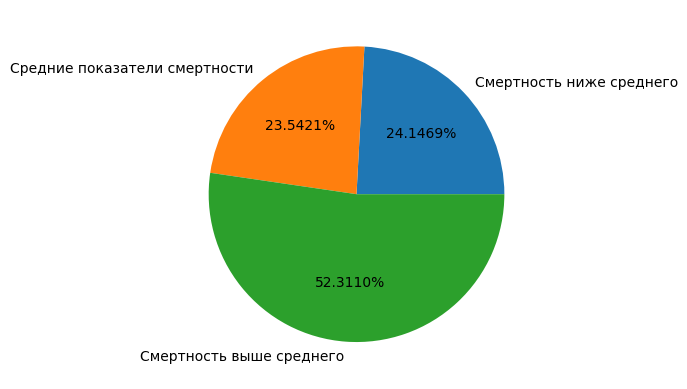

In [46]:
part1 = below_average_df.count()
part2 = average_df.count()
part3 = above_average_df.count()

values = [part1, part2, part3]
labels = ['Смертность ниже среднего', 'Средние показатели смертности', 'Смертность выше среднего']

plt.pie(values, labels=labels, autopct='%1.4f%%')
plt.show()

создаем 'точечную' диаграмму рассеивания между рождаемостью и смертностью

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

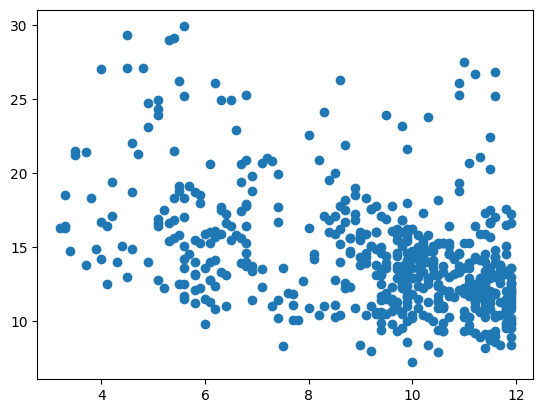

In [64]:
below_average_pd = below_average_df.select('death_rate', 'birth_rate').toPandas()
#диаграммма рассеивания
plt.scatter(below_average_pd['death_rate'], below_average_pd['birth_rate'])
plt.show()

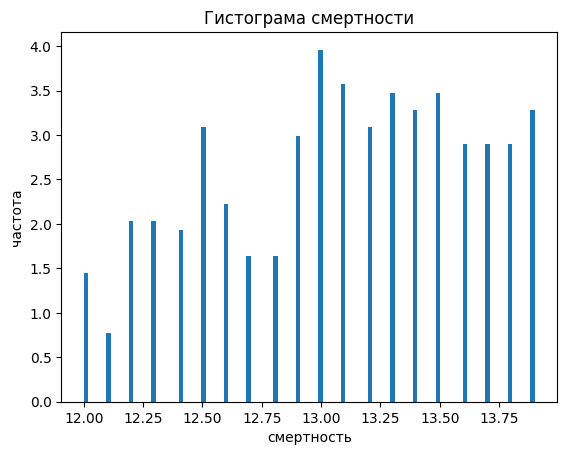

In [48]:
# Преобразуем столбец 'death_rate' в формат Pandas DataFrame для построения гистограммы
death_rate_data = average_df.select('death_rate').toPandas()

# Строим гистограмму с помощью библиотеки Matplotlib
plt.hist(death_rate_data['death_rate'], bins=100, density=True)
plt.xlabel('смертность')
plt.ylabel('частота')
plt.title('Гистограма смертности')
plt.show()

In [49]:
# Вызываем функцию describe() для получения статистики по числовым столбцам
description = df.describe()

# Выводим статистику
description.show()

+-------+------------------+----------------+------------------+------------------+------------------+------------------+------------------+
|summary|              year|          region|               npg|        birth_rate|        death_rate|               gdw|      urbanization|
+-------+------------------+----------------+------------------+------------------+------------------+------------------+------------------+
|  count|              2315|            2315|              2315|              2315|              2315|              2315|              2315|
|   mean|2003.5831533477321|            NULL|-2.344276457883365|11.548207343412503|13.901382289416865| 68.34516630669563| 69.37533909287248|
| stddev|  8.09015596803327|            NULL| 6.066994590690594| 3.234236424031502| 3.499474931393436|10.351930383595063|13.081548945803013|
|    min|              1990|      Altai Krai|             -15.9|               6.2|               3.2|              37.5|             23.63|
|    max|    

In [65]:
# Группируем по столбцу 'year' и вычисляем средние значения для 'birth_rate' и 'death_rate'
df_gb = df.groupBy('year').agg(mean('birth_rate').alias('mean_birth_rate'), mean('death_rate').alias('mean_death_rate'))

# Выводим результат
df_gb.show(100)

+----+------------------+------------------+
|year|   mean_birth_rate|   mean_death_rate|
+----+------------------+------------------+
|1990|14.354878048780485|10.542682926829269|
|2003| 10.89277108433735| 16.23855421686747|
|2007|12.054216867469883| 14.48915662650602|
|2015| 13.51529411764706|13.131764705882356|
|2006|10.974698795180723|15.119277108433733|
|2013| 13.67469879518072|13.126506024096383|
|1997| 9.240243902439024|13.307317073170733|
|1994|10.228395061728396|15.009876543209884|
|2014|13.713253012048195|13.131325301204818|
|2004|11.099999999999998|15.862650602409632|
|1991|12.971951219512201|10.775609756097559|
|1996| 9.558536585365855|13.732926829268287|
|1998| 9.487804878048776|13.149999999999999|
|2012|13.827710843373492| 13.36385542168675|
|2009| 12.95903614457831|14.162650602409643|
|2016|13.043529411764707| 12.95764705882353|
|1995|10.021951219512196|14.341463414634152|
|2001| 9.690243902439025| 15.30243902439025|
|1992|11.479268292682926| 11.58780487804878|
|2005|10.8

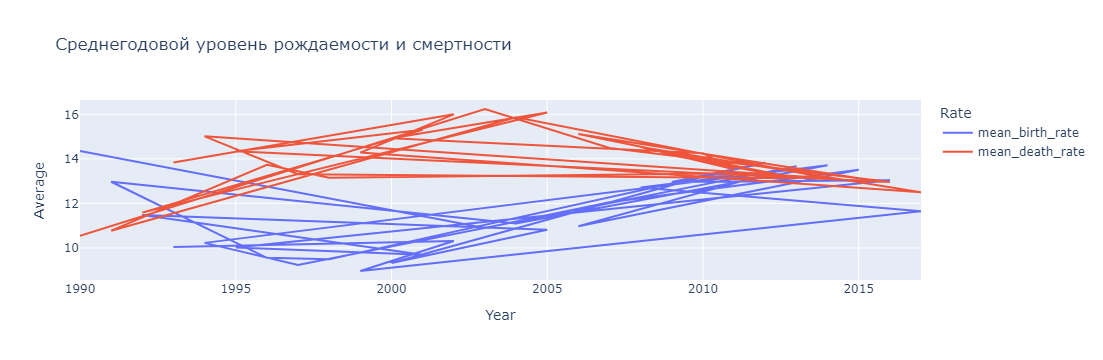

In [66]:
# Преобразуем DataFrame PySpark в Pandas DataFrame для использования с Plotly
df_pd = df_gb.toPandas()
# Используем Plotly Express для создания интерактивного графика
fig = px.line(df_pd, x='year', y=['mean_birth_rate', 'mean_death_rate'],
              title='Среднегодовой уровень рождаемости и смертности',
              labels={'year': 'Year', 'value': 'Average', 'variable': 'Rate'},
              line_shape='linear')

# Отображаем график
fig.show()

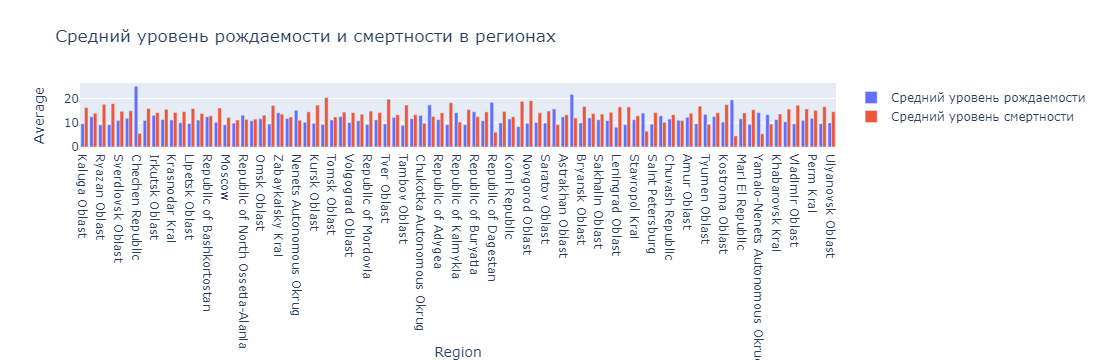

In [52]:
# Агрегируем данные по регионам и вычисляем средние значения
df_agg = df.groupBy('region').agg(mean('birth_rate').alias('avg_birth_rate'), mean('death_rate').alias('avg_death_rate'))

# Используем collect() для получения данных на локальную машину
data = df_agg.collect()

# Создаем списки для значений оси x (регионы) и значений оси y (средние значения)
regions = [row['region'] for row in data]
avg_birth_rates = [row['avg_birth_rate'] for row in data]
avg_death_rates = [row['avg_death_rate'] for row in data]

# Строим график
trace1 = go.Bar(x=regions, y=avg_birth_rates, name='Средний уровень рождаемости')
trace2 = go.Bar(x=regions, y=avg_death_rates, name='Средний уровень смертности')

layout = go.Layout(title='Средний уровень рождаемости и смертности в регионах',
                   xaxis=dict(title='Region'),
                   yaxis=dict(title='Average'))

fig = go.Figure(data=[trace1, trace2], layout=layout)
iplot(fig)

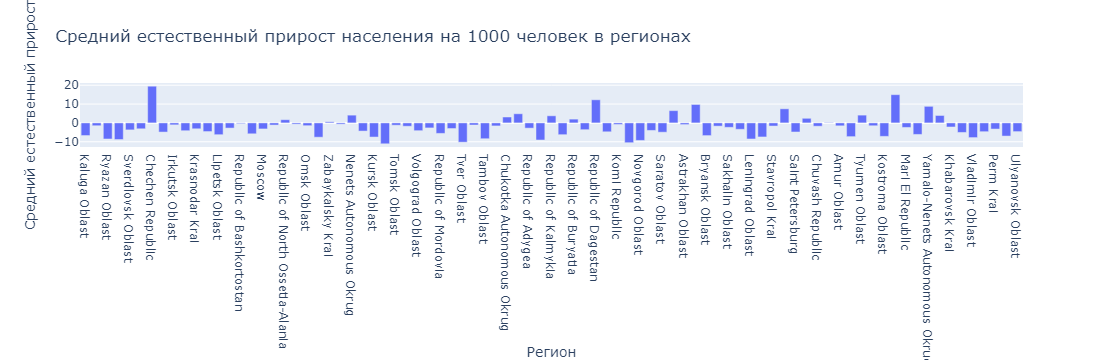

In [53]:
# Агрегируем данные по регионам и вычисляем средние значения NPG
df_npg = df.groupBy('region').agg(mean('npg').alias('avg_npg'))

# Используем collect() для получения данных на локальную машину
data = df_npg.collect()

# Создаем списки для значений оси x (регионы) и значений оси y (средние значения NPG)
regions = [row['region'] for row in data]
avg_npg = [row['avg_npg'] for row in data]

# Строим график
trace = go.Bar(x=regions, y=avg_npg)

layout = go.Layout(title='Средний естественный прирост населения на 1000 человек в регионах',
                   xaxis=dict(title='Регион'),
                   yaxis=dict(title='Средний естественный прирост'))

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

В регионах с высоким процентом городского населения общий демографический вес меньше, чем в регионах с небольшим показателем. В крупных городах в семьях рождается меньше детей, чем в городах и деревнях. Также мы видим, что в первые 10 лет нового столетия общий демографический вес был значительно ниже, чем в другие периоды. Это может быть связано с низким уровнем рождаемости и высокой смертностью в это время

In [54]:
# Выбираем строки, соответствующие указанным регионам
df_capital = df.filter((df['region'] == 'Moscow') | (df['region'] == 'Saint Petersburg') | (df['region'] == 'Leningrad Oblast') | (df['region'] == 'Moscow Oblast'))

# Удаляем указанные столбцы из DataFrame
columns_to_drop = ['npg', 'birth_rate', 'death_rate', 'gdw']
df_capital = df_capital.drop(*columns_to_drop)

# Показываем DataFrame с результатами
df_capital.show()

+----+----------------+------------+
|year|          region|urbanization|
+----+----------------+------------+
|1990|Leningrad Oblast|       66.05|
|1990|          Moscow|       100.0|
|1990|   Moscow Oblast|       79.67|
|1990|Saint Petersburg|       100.0|
|1991|Leningrad Oblast|       66.09|
|1991|          Moscow|       100.0|
|1991|   Moscow Oblast|       79.68|
|1991|Saint Petersburg|       100.0|
|1992|Leningrad Oblast|       66.21|
|1992|          Moscow|       100.0|
|1992|   Moscow Oblast|        79.7|
|1992|Saint Petersburg|       100.0|
|1993|Leningrad Oblast|       66.24|
|1993|          Moscow|       100.0|
|1993|   Moscow Oblast|       79.69|
|1993|Saint Petersburg|       100.0|
|1994|Leningrad Oblast|       66.24|
|1994|          Moscow|       100.0|
|1994|   Moscow Oblast|       79.64|
|1994|Saint Petersburg|       100.0|
+----+----------------+------------+
only showing top 20 rows



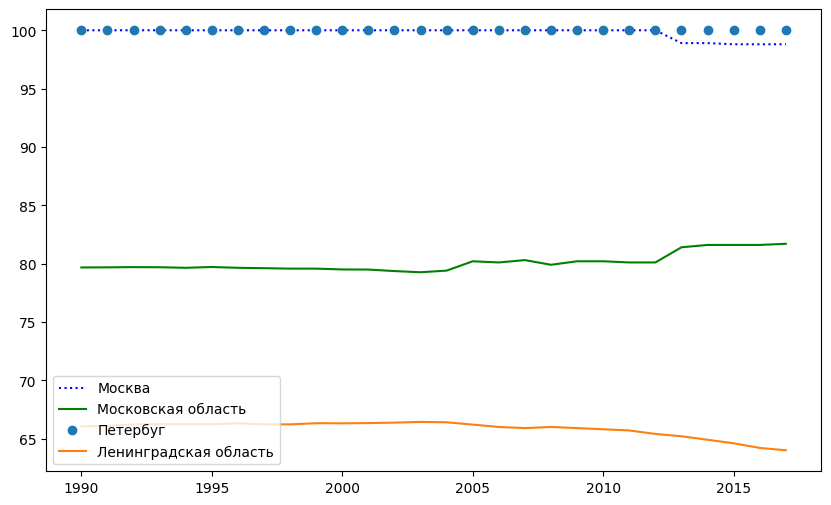

In [55]:
# Преобразуем DataFrame PySpark в pandas DataFrame для построения графика
df_capital_pandas = df_capital.toPandas()

# Создаем график
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df_capital_pandas['year'][df_capital_pandas['region']=='Moscow'],
        df_capital_pandas['urbanization'][df_capital_pandas['region']=='Moscow'], ':b', label='Москва')
ax.plot(df_capital_pandas['year'][df_capital_pandas['region']=='Moscow Oblast'],
        df_capital_pandas['urbanization'][df_capital_pandas['region']=='Moscow Oblast'], '-g', label='Московская область')
ax.plot(df_capital_pandas['year'][df_capital_pandas['region']=='Saint Petersburg'],
        df_capital_pandas['urbanization'][df_capital_pandas['region']=='Saint Petersburg'], 'o', label='Петербуг')
ax.plot(df_capital_pandas['year'][df_capital_pandas['region']=='Leningrad Oblast'],
        df_capital_pandas['urbanization'][df_capital_pandas['region']=='Leningrad Oblast'], label='Ленинградская область')

# Добавляем легенду
plt.legend()

# Отображаем график
plt.show()

Из этой таблицы видно, что урбанизация Москвы становится все меньше, а Московской области - все больше. Это было связано с официальным расширением административных границ Москвы за счет территории Московской области в 2012 году. В Ленинградской области увеличилось сельское население и сократилась численность городского населения.

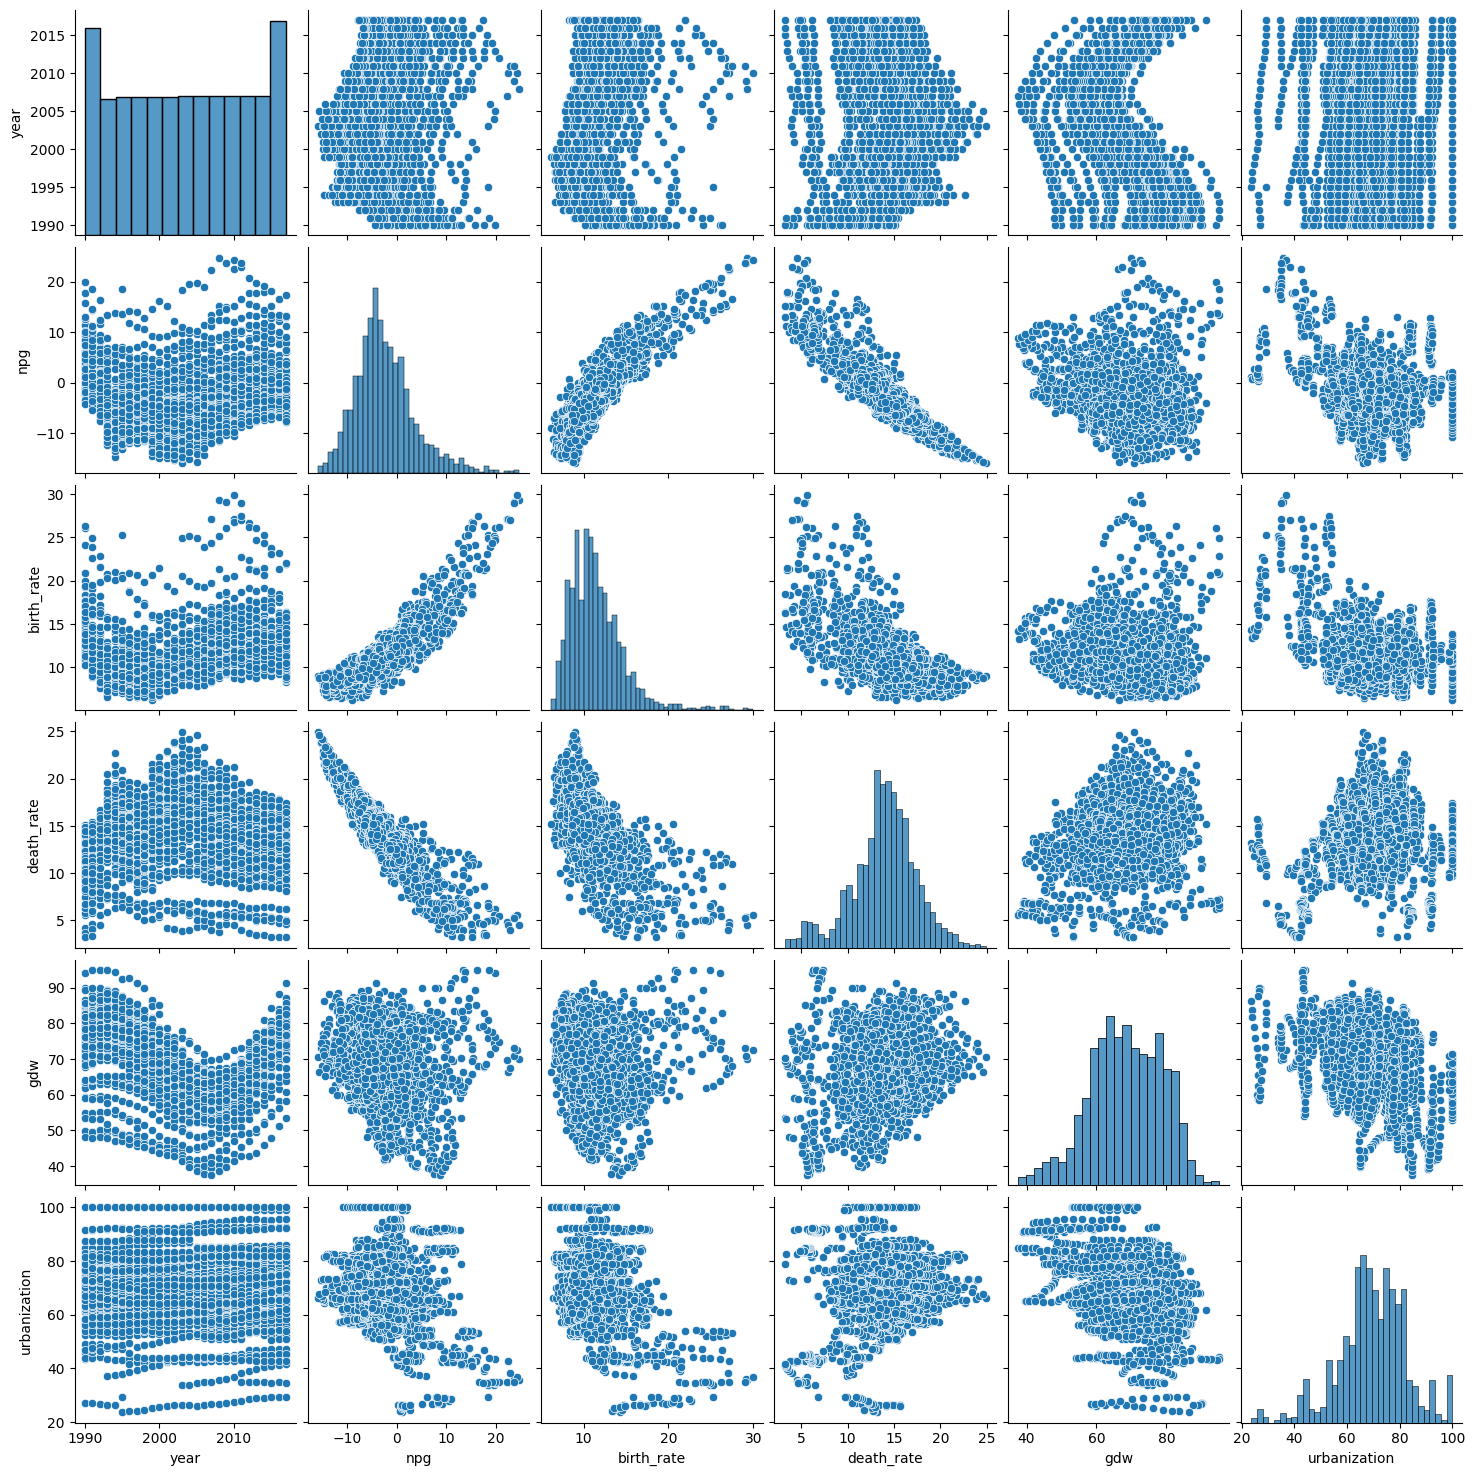

In [56]:
# Преобразуем его в Pandas DataFrame для использования с библиотекой seaborn
df_pandas = df.toPandas()

# Построение pairplot
sns.pairplot(df_pandas, kind='scatter', diag_kind='hist', palette='lightblue')

In [57]:
spark